# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. In particular, our model will be fed a text query and will return several images that are related to the query. To do this task, our model will be trained so that it embeds both image and text data into the same space, and importantly, encodes relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function. <br>
<br>
In this notebook, I implement the DataLoader for training the Dual-Encoder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [4]:
print(f"dataset has two keys: images, texts")
print(f"Number of images: ", len(dataset["images"]))
print(f"Size of each image: ", dataset["images"][0].shape)
print(f"Number of texts: ", len(dataset["texts"]))

dataset has two keys: images, texts
Number of images:  4500
Size of each image:  (299, 299, 3)
Number of texts:  45000


In [5]:
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


For $i$-th image, the corresponding captions are stored in $(i \times 10)$ to $(i \times 10 + 9)$ rows in texts.

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

In [7]:
class DualEncoderDataset(Dataset):
    def __init__(self, images, texts, neg_rate=4):
        # This class assumes that num_image < num_texts, and the number of texts per image is the same for all images.
        self.imagedata = images
        self.textdata = texts
        self.num_images = len(images)
        self.num_texts = len(texts)
        self.image_text_rate = int(self.num_texts / self.num_images)
        self.num_negative = int(self.num_texts * neg_rate)
        self.random_map = []
        self.shuffle()
    
    def shuffle(self):
        self.random_map = np.random.randint(0, self.num_texts - self.image_text_rate, self.num_negative)
        for i in range(self.num_negative):
            if self.random_map[i] >= i % self.num_texts // self.image_text_rate * self.image_text_rate:
                self.random_map[i] += self.image_text_rate
    
    def __len__(self):
        return self.num_texts + self.num_negative

    def __getitem__(self, sample_idx):
        if torch.is_tensor(sample_idx):
            sample_idx = sample_idx[0].tolist()
        image_idx = sample_idx % self.num_texts // self.image_text_rate
        if sample_idx < self.num_texts:
            text_idx = sample_idx
        else:
            text_idx = self.random_map[sample_idx - self.num_texts]
        sample = {"image": self.imagedata[image_idx], "text": self.textdata[text_idx], "label": int(sample_idx < self.num_texts)}
        return sample

In [8]:
def show10samples(batch):
    label_dec = {1: "positive", 0: "negative"}
    plt.figure(figsize=(15,6))
    for i in range(10):
        if i < len(batch["label"]):
            plt.subplot(2, 5, i + 1)
            img = batch["image"][i].cpu().numpy()
            img = np.flip(img, axis=-1)
            plt.imshow(img)
            plt.title("[" + str(i) + "] " + label_dec[batch["label"][i].tolist()] + " pair")
    plt.tight_layout()
    plt.show()
    for i in range(10):
        print("[" + str(i) + "] | " + label_dec[batch["label"][i].tolist()] + ": " + batch["text"][i])

In [15]:
batch_size = 10
trainloader = DataLoader(DualEncoderDataset(train_images, train_texts, neg_rate=4), batch_size=batch_size, shuffle=True)
testloader = DataLoader(DualEncoderDataset(test_images, test_texts, neg_rate=0), batch_size=batch_size, shuffle=True)

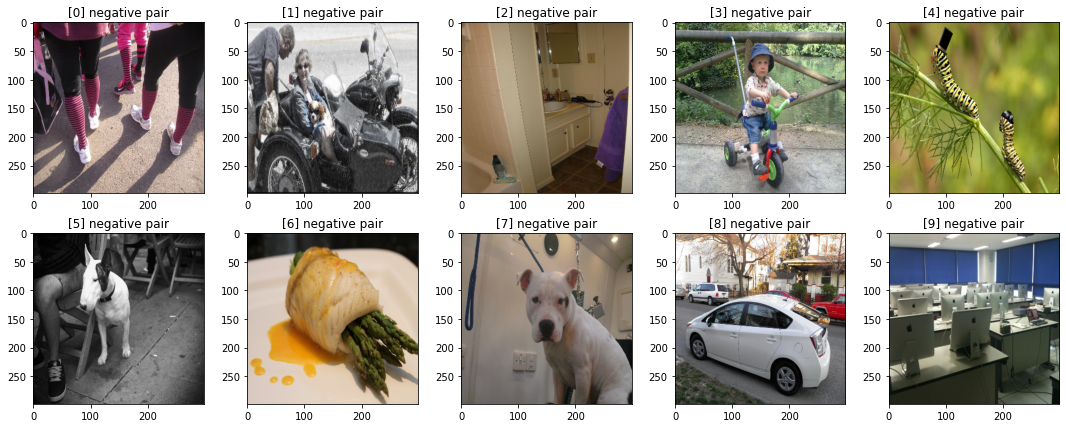

[0] | negative: The sun shines on trees next to a street light with a picture of a sun.
[1] | negative: A goose is spreading his wings in the water next to another goose on the water.
[2] | negative: A man wearing a shirt and tie, playing an accordion.
[3] | negative: Man wearing white hat, tan jacket and jeans standing by glass entry door on garage. 
[4] | negative: This blue and white bowl contains broccoli and nuts.
[5] | negative: A woman in grey pants and brown t-shirt standing in front of some trees gets ready to fire a very long arrow with a large, thin bow.
[6] | negative: The tattoo is all black and white except for a blue crying eye.
[7] | negative: A man in a wheelchair holding a ping pong paddle in the air.
[8] | negative: An up-close view of pizza white cheese and seasoning. 
[9] | negative: A man driving a blue and silver fork lifter.


In [16]:
for i, batch in enumerate(trainloader):
    show10samples(batch)
    break

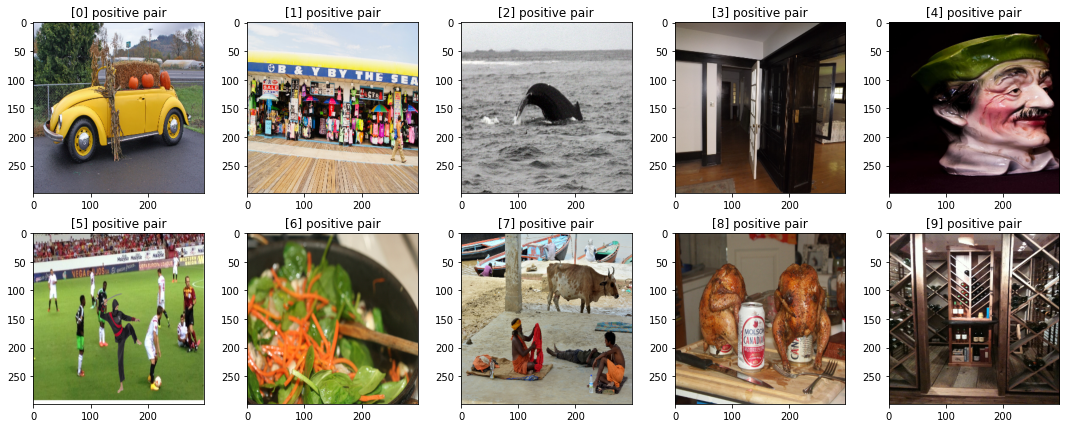

[0] | positive: A yellow car with hay and pumpkins on it. 
[1] | positive: A store front is lined with many colorful items of clothing. 
[2] | positive: a dolphin is diving into the water making a splash
[3] | positive: Rooms of a house with hardwood floors and black and white walls.
[4] | positive: A painted porcelain figure features a mustached man in a beret.
[5] | positive: A fighter holding a sword in the middle of a football field with other players 
[6] | positive: The salad of carrots and lettuce is on the stove. 
[7] | positive: Some native people sitting on the ground while a cow walks by.
[8] | positive: Individual cooked chickens sit on cans of beer.
[9] | positive: A collection of racks contain many bottles of wine.


In [17]:
for i, batch in enumerate(testloader):
    show10samples(batch)
    break